# Project 71: Automatic Image Caption Generation

## Authors: Oihane Cantero and Julen Etxaniz

## Supervisors: Oier Lopez de Lacalle and Eneko Agirre

## Subject: Machine Learning and Neural Networks

## Date: 20-12-2020

## Objectives: 
### **1. Implement a caption generation model that uses a CNN to condition a LSTM based language model.**
### 2. Extend the basic caption generation system that incorporates an attention mechanism to the model.

## Contents:
### [1.Import Libraries](#1.-Import-Libraries)
### [2.Get Dataset](#2.-Get-Dataset)
### [3.Prepare Photo Data](#3.-Prepare-Photo-Data)
### [4.Prepare Text Data](#4.-Prepare-Text-Data)
### [5.Load Data](#5.-Load-Data)
### [6.Encode Text Data](#6.-Encode-Text-Data)
### [7.Define Model](#7.-Define-Model)
### [8.Fit Model](#8.-Fit-Model)
### [9.Evaluate Model](#9.-Evaluate-Model)
### [10.Generate Captions](#10.-Generate-Captions)

## References
[1] https://arxiv.org/pdf/1411.4555.pdf

[2] https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/

[3] https://github.com/dabasajay/Image-Caption-Generator

[4] https://github.com/yashk2810/Image-Captioning

# 1. Import Libraries

In [4]:
# Prepare Photo Data
from os import listdir
from os.path import isfile
from pickle import dump
from tqdm import tqdm
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import matplotlib.pyplot as plt

# Prepare Text Data
import string

# Load Data
from pickle import load

# Encode Text Data
from keras.preprocessing.text import Tokenizer

# Define Model
from keras.utils import plot_model
from keras.models import Model
from keras.models import load_model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers.merge import add
from keras.layers import RepeatVector, TimeDistributed, concatenate, Bidirectional

# Fit Model
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# Evaluate Model
from numpy import argmax, argsort
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu, SmoothingFunction

# Generate Captions
from IPython.display import Image, display

# 2. Get Dataset

We decided to use Flickr8k Dataset. It can be downloaded from: https://github.com/jbrownlee/Datasets/releases/tag/Flickr8k

It has 8092 images and 5 captions for each image. Each image has 5 captions because obviously, there are different ways to caption an image. This dataset has predefined training, testing and evaluation subsets of 6000, 1000 and 1000 images respectively.

# 3. Prepare Photo Data
Two different models to extract image features: VGG16 and InceptionV3.

In [5]:
# preprocess the image for the model
def preprocess_image(filename, image_size):
    image = load_img(filename, target_size=(image_size, image_size))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    # reshape data for the model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # prepare the image for the model
    image = preprocess_input(image)
    return image

In [6]:
# extract features from each photo in the directory
def extract_features(directory, model, image_size):
	# extract features from each photo
	features = dict()
	for name in tqdm(listdir(directory), position=0, leave=True):
		# load an image from file
		filename = directory + '/' + name
		# preprocess the image for the model
		image = preprocess_image(filename, image_size)
		# get features
		feature = model.predict(image, verbose=0)
		# get image id
		image_id = name.split('.')[0]
		# store feature
		features[image_id] = feature
	return features

In [7]:
def plot(model, filename):
    plot_model(model, to_file=filename, show_shapes=True, show_layer_names=False)
    display(Image(filename))

## 3.1. VGG16 Model

In [8]:
from keras.applications.vgg16 import preprocess_input

In [9]:
# cnn VGG16 model
def cnn_vgg16():
    # load the model
    model = VGG16()
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # summarize
    print(model.summary())
    return model

In [10]:
# get cnn vgg16 model
cnn_vgg16 = cnn_vgg16()

553467904/553467096 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

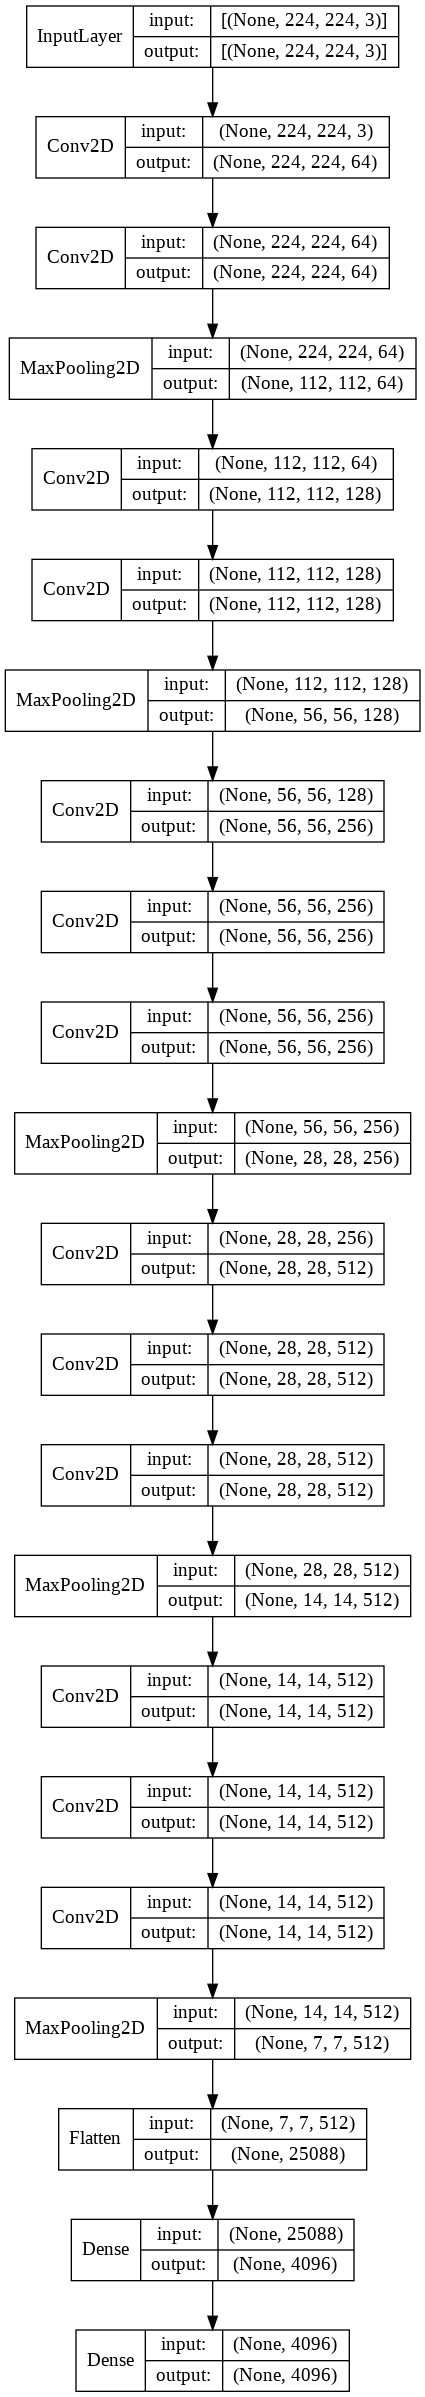

In [ ]:
# plot model
filename = 'models/cnn_vgg16.png'
plot(cnn_vgg16, filename)

In [ ]:
filename = 'files/features_vgg16.pkl'
# only extract if file does not exist
if not isfile(filename):
    # extract features from all images
    directory = 'Flickr8k_Dataset'
    features = extract_features(directory, cnn_vgg16, 224)
    # save to file
    dump(features, open(filename, 'wb'))

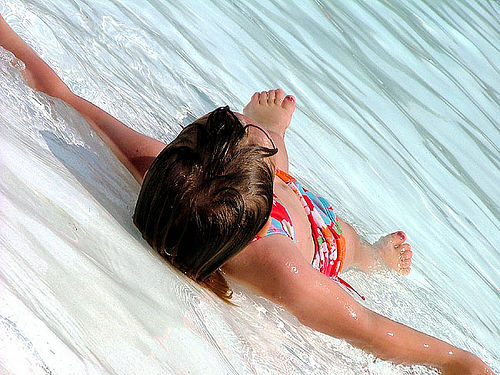

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


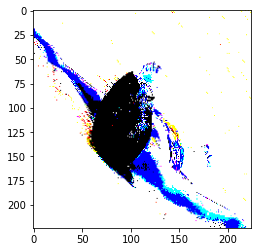

In [ ]:
# display original and preprocessed image
example_image = "Flickr8k_Dataset/667626_18933d713e.jpg"
display(Image(example_image))
image = preprocess_image(example_image, 224)
plt.imshow(np.squeeze(image))

## 3.2. InceptionV3 Model

In [ ]:
from keras.applications.inception_v3 import preprocess_input

In [ ]:
# cnn InceptionV3 model
def cnn_inceptionv3():
    # load the model
    model = InceptionV3(weights='imagenet')
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
    # summarize
    print(model.summary())
    return model

In [ ]:
# get cnn inceptionv3 model
cnn_inceptionv3 = cnn_inceptionv3()

96116736/96112376 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_____________________________

In [ ]:
# plot model
filename = 'models/cnn_inceptionv3.png'
plot(cnn_inceptionv3, filename)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
filename = 'files/features_inceptionv3.pkl'
# only extract if file does not exist
if not isfile(filename):
    # extract features from all images
    directory = 'Flickr8k_Dataset'
    features = extract_features(directory, cnn_vgg16, 224)
    # save to file
    dump(features, open(filename, 'wb'))

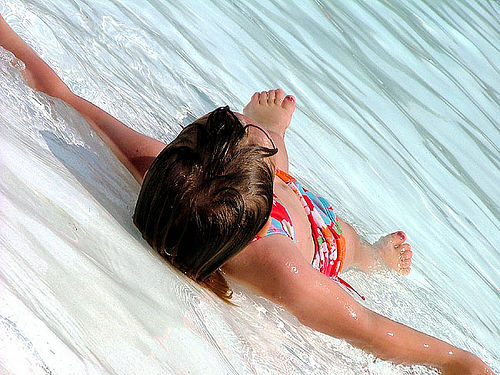

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


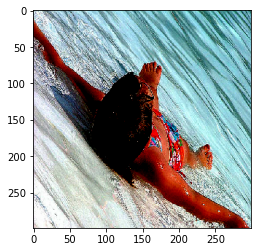

In [ ]:
# display original and preprocessed image
example_image = "Flickr8k_Dataset/667626_18933d713e.jpg"
display(Image(example_image))
image = preprocess_image(example_image, 299)
plt.imshow(np.squeeze(image))

# 4. Prepare Text Data

In [11]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

In [12]:
# extract descriptions for images
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# remove filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

In [13]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

In [14]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

In [15]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

In [ ]:
filename = 'Flickr8k_text/Flickr8k.token.txt'
# load descriptions
doc = load_doc(filename)
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 8092 


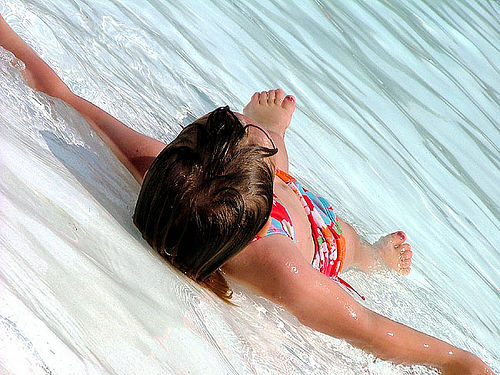

In [ ]:
display(Image(example_image))

In [ ]:
example_id = '667626_18933d713e'
descriptions[example_id]

['A girl is stretched out in shallow water',
 'A girl wearing a red and multi-colored bikini is laying on her back in shallow water .',
 'A little girl in a red swimsuit is laying on her back in shallow water .',
 'A young girl is lying in the sand , while ocean water is surrounding her .',
 'Girl wearing a bikini lying on her back in a shallow pool of clear blue water .']

In [ ]:
# clean descriptions
clean_descriptions(descriptions)
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))
# save to file
save_descriptions(descriptions, 'files/descriptions.txt')

Vocabulary Size: 8763


In [ ]:
descriptions[example_id]

['girl is stretched out in shallow water',
 'girl wearing red and multicolored bikini is laying on her back in shallow water',
 'little girl in red swimsuit is laying on her back in shallow water',
 'young girl is lying in the sand while ocean water is surrounding her',
 'girl wearing bikini lying on her back in shallow pool of clear blue water']

# 5. Load Data

In [16]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

In [17]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = '<start> ' + ' '.join(image_desc) + ' <end>'
			# store
			descriptions[image_id].append(desc)
	return descriptions

In [18]:
# load photo features
def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features

## 5.1. Train Data

In [19]:
# load training dataset (6K)
filename = 'Flickr8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))
# descriptions
train_descriptions = load_clean_descriptions('files/descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# photo features
train_features = load_photo_features('files/features_vgg16.pkl', train) #files/features_inceptionv3 or files/features_vgg16
print('Photos: train=%d' % len(train_features))

Dataset: 6000
Descriptions: train=6000
Photos: train=6000


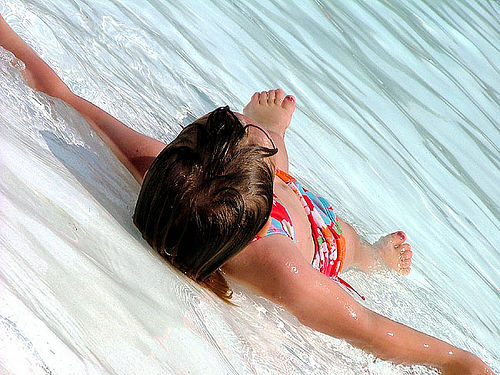

In [ ]:
display(Image(example_image))

In [ ]:
# <start> and <end> added
train_descriptions[example_id]

['<start> girl is stretched out in shallow water <end>',
 '<start> girl wearing red and multicolored bikini is laying on her back in shallow water <end>',
 '<start> little girl in red swimsuit is laying on her back in shallow water <end>',
 '<start> young girl is lying in the sand while ocean water is surrounding her <end>',
 '<start> girl wearing bikini lying on her back in shallow pool of clear blue water <end>']

In [ ]:
# features of previous image
train_features[example_id]

array([[0.39258254, 0.17952543, 0.5020331 , ..., 0.31590924, 0.616592  ,
        0.37674323]], dtype=float32)

## 5.2. Validation Data

In [20]:
# load val dataset
filename = 'Flickr8k_text/Flickr_8k.devImages.txt'
val = load_set(filename)
print('Dataset: %d' % len(val))
# descriptions
val_descriptions = load_clean_descriptions('files/descriptions.txt', val)
print('Descriptions: val=%d' % len(val_descriptions))
# photo features
val_features = load_photo_features('files/features_vgg16.pkl', val)#files/features_inceptionv3 or files/features_vgg16
print('Photos: val=%d' % len(val_features))

Dataset: 1000
Descriptions: val=1000
Photos: val=1000


## 5.3. Test Data

In [21]:
# load test set
filename = 'Flickr8k_text/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('files/descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('files/features_vgg16.pkl', test)#files/features_inceptionv3 or files/features_vgg16
print('Photos: test=%d' % len(test_features))

Dataset: 1000
Descriptions: test=1000
Photos: test=1000


# 6. Encode Text Data

In [22]:
# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

In [23]:
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer(filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~ ')
	tokenizer.fit_on_texts(lines)
	return tokenizer

In [24]:
# calculate the length of the description with the most words
def max_len(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

In [25]:
# prepare tokenizer
filename = 'files/tokenizer.pkl'
# only create tokenizer if it does not exist
if not isfile(filename):
    tokenizer = create_tokenizer(train_descriptions)
    # save the tokenizer
    dump(tokenizer, open(filename, 'wb'))
else:
    tokenizer = load(open(filename, 'rb'))
# define vocabulary size
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
max_length = max_len(train_descriptions)
print('Description Length: %d' % max_length)

Vocabulary Size: 7579
Description Length: 34


In [ ]:
# 10 most common words
list(tokenizer.word_index.items())[:10]

[('<start>', 1),
 ('<end>', 2),
 ('in', 3),
 ('the', 4),
 ('on', 5),
 ('is', 6),
 ('and', 7),
 ('dog', 8),
 ('with', 9),
 ('man', 10)]

In [ ]:
# 10 least common words
list(tokenizer.word_index.items())[-10:]

[('exotic', 7569),
 ('swatting', 7570),
 ('containig', 7571),
 ('rainstorm', 7572),
 ('breezeway', 7573),
 ('cocker', 7574),
 ('spaniels', 7575),
 ('majestically', 7576),
 ('scrolled', 7577),
 ('patterns', 7578)]

# 7. Define Model

In [ ]:
from keras.backend import clear_session
clear_session()

## 7.1. Model 1

In [26]:
# define the captioning model
def rnn_model_1(vocab_size, max_length, embedding_size, units, input_size):
    # feature extractor model
    inputs1 = Input(shape=(input_size,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(embedding_size, activation='relu')(fe1)
    # sequence model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, embedding_size, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(units)(se2)
    # decoder model
    decoder1 = add([fe2, se3])
    decoder2 = Dense(units, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)
    # tie it together [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    return model

### 7.1.1. Model 1 VGG16

In [ ]:
# define the model
embedding_size = 256
units = 256
input_size = 4096
model = rnn_model_1(vocab_size, max_length, embedding_size, units, input_size)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 256)      1940224     input_2[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 4096)         0           input_1[0][0]                    
______________________________________________________________________________________________

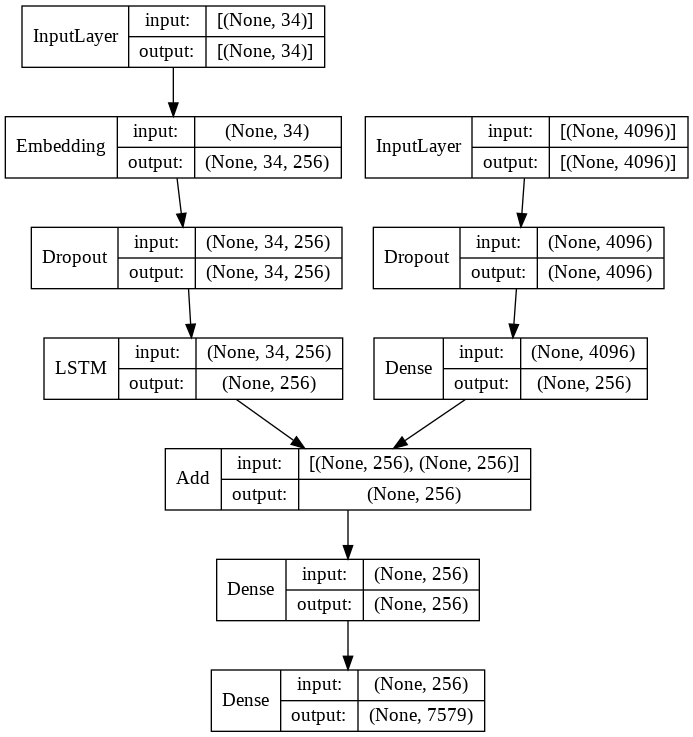

In [ ]:
# plot model
filename = 'models/rnn_model_1_vgg16.png'
plot(model, filename)

### 7.1.2. Model 1 InceptionV3

In [ ]:
# define the model
embedding_size = 256
units = 256
input_size = 2048
model = rnn_model_1(vocab_size, max_length, embedding_size, units, input_size)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      1940224     input_4[0][0]                    
__________________________________________________________________________________________________
dropout_2 (Dropout)             (None, 2048)         0           input_3[0][0]                    
____________________________________________________________________________________________

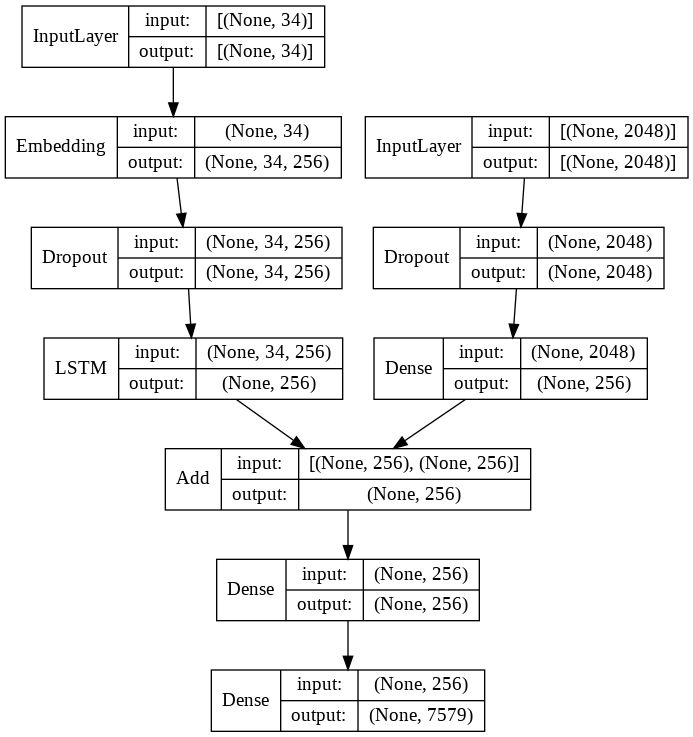

In [ ]:
# plot model
filename = 'models/rnn_model_1_inceptionv3.png'
plot(model, filename)

## 7.2. Model 2

In [27]:
# define the captioning model
def rnn_model_2(vocab_size, max_length, embedding_size, units, input_size):
    image_input = Input(shape=(input_size,))
    image_model_1 = Dense(embedding_size, activation='relu')(image_input)
    image_model = RepeatVector(max_length)(image_model_1)

    caption_input = Input(shape=(max_length,))
    # mask_zero: We zero pad inputs to the same length, the zero mask ignores those inputs
    caption_model_1 = Embedding(vocab_size, embedding_size, mask_zero=True)(caption_input)
    # Since we are going to predict the next word using the previous words, we have to set return_sequences = True.
    caption_model_2 = LSTM(units, return_sequences=True)(caption_model_1)
    caption_model = TimeDistributed(Dense(embedding_size))(caption_model_2)

    # Merging the models and creating a softmax classifier
    final_model_1 = concatenate([image_model, caption_model])
    final_model_2 = Bidirectional(LSTM(units, return_sequences=False))(final_model_1)
    final_model_3 = Dense(units, activation='relu')(final_model_2)
    final_model = Dense(vocab_size, activation='softmax')(final_model_3)

    model = Model(inputs=[image_input, caption_input], outputs=final_model)
    model.compile(loss='categorical_crossentropy', optimizer='adam')
    # summarize model
    print(model.summary())
    return model

### 7.2.1. Model 2 VGG16

In [28]:
# define the model
embedding_size = 256
units = 256
input_size = 4096
model = rnn_model_2(vocab_size, max_length, embedding_size, units, input_size)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 34, 256)      1940224     input_3[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          1048832     input_2[0][0]                    
____________________________________________________________________________________________

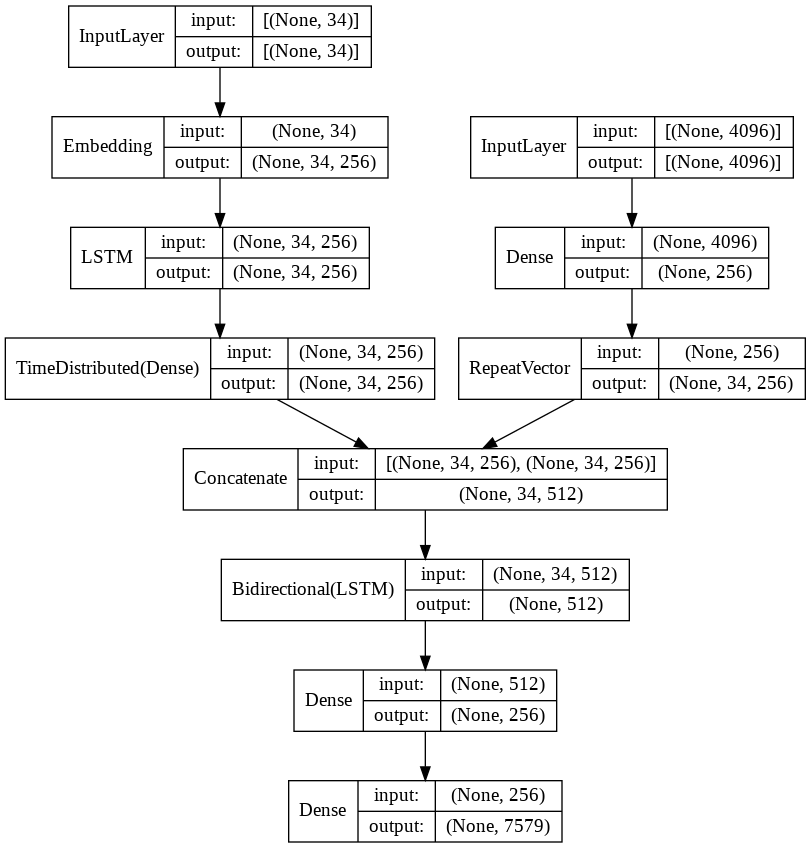

In [ ]:
# plot model
filename = 'models/rnn_model_2_vgg16.png'
plot(model, filename)

### 7.2.2. Model 2 InceptionV3

In [48]:
# define the model
embedding_size = 256
units = 256
input_size = 2048
model = rnn_model_2(vocab_size, max_length, embedding_size, units, input_size)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 34, 256)      1940224     input_5[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 256)          524544      input_4[0][0]                    
____________________________________________________________________________________________

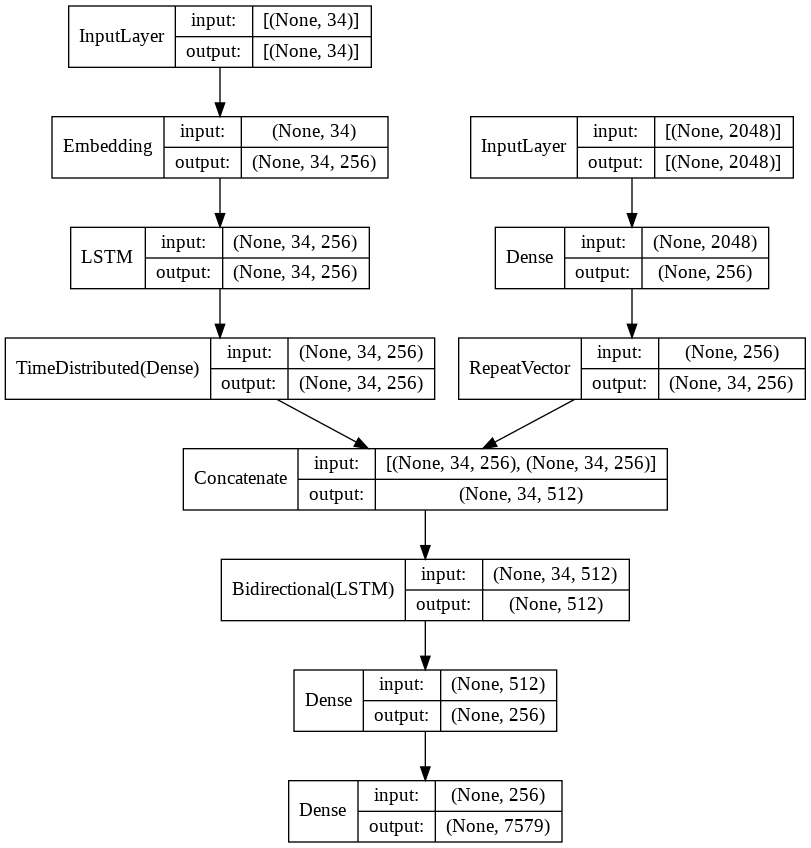

In [ ]:
# plot model
filename = 'models/rnn_model_2_inceptionv3.png'
plot(model, filename)

# 8. Fit Model

In [29]:
# Create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, captions_list, image):
	# X1 : input for image features
	# X2 : input for text features
	# y  : output word
	X1, X2, y = list(), list(), list()
	vocab_size = len(tokenizer.word_index) + 1
	# Walk through each caption for the image
	for caption in captions_list:
		# Encode the sequence
		seq = tokenizer.texts_to_sequences([caption])[0]
		# Split one sequence into multiple X,y pairs
		for i in range(1, len(seq)):
			# Split into input and output pair
			in_seq, out_seq = seq[:i], seq[i]
			# Pad input sequence
			in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
			# Encode output sequence
			out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
			# Store
			X1.append(image)
			X2.append(in_seq)
			y.append(out_seq)
	return X1, X2, y

In [30]:
# Data generator, intended to be used in a call to model.fit()
def data_generator(images, captions, tokenizer, max_length, batch_size, random_seed):
	# Setting random seed for reproducibility of results
	random.seed(random_seed)
	# Image ids
	image_ids = list(captions.keys())
	_count=0
	while True:
		if _count >= len(image_ids):
			# Generator exceeded or reached the end so restart it
			_count = 0
		# Batch list to store data
		input_img_batch, input_sequence_batch, output_word_batch = list(), list(), list()
		for i in range(_count, min(len(image_ids), _count+batch_size)):
			# Retrieve the image id
			image_id = image_ids[i]
			# Retrieve the image features
			image = images[image_id][0]
			# Retrieve the captions list
			captions_list = captions[image_id]
			# Shuffle captions list
			random.shuffle(captions_list)
			input_img, input_sequence, output_word = create_sequences(tokenizer, max_length, captions_list, image)
			# Add to batch
			for j in range(len(input_img)):
				input_img_batch.append(input_img[j])
				input_sequence_batch.append(input_sequence[j])
				output_word_batch.append(output_word[j])
		_count = _count + batch_size
		yield ([np.array(input_img_batch), np.array(input_sequence_batch)], np.array(output_word_batch))

In [31]:
# define parameters
num_of_epochs = 20
batch_size = 32
train_length = len(train_descriptions)
val_length = len(val_descriptions)
steps_train = train_length // batch_size
if train_length % batch_size != 0:
    steps_train = steps_train+1
steps_val = val_length // batch_size
if val_length % batch_size != 0:
    steps_val = steps_val+1

In [32]:
import random
# Setting random seed for reproducibility of results
random.seed('1000')
# Shuffle train data
ids_train = list(train_descriptions.keys())
random.shuffle(ids_train)
train_descriptions = {_id: train_descriptions[_id] for _id in ids_train}

In [33]:
# Create the train data generator
generator_train = data_generator(train_features, train_descriptions, tokenizer, max_length, batch_size, random_seed='1000')
# Create the validation data generator
generator_val = data_generator(val_features, val_descriptions, tokenizer, max_length, batch_size, random_seed='1000')

In [34]:
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
# define checkpoint callback
filepath = 'models/rnn_model_2_vgg16.h5'
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# define early stopping callback
early = EarlyStopping(patience=1, verbose=1)

In [35]:
# Fit
history = model.fit(generator_train,
            epochs=num_of_epochs,
            steps_per_epoch=steps_train,
            validation_data=generator_val,
            validation_steps=steps_val,
            callbacks=[checkpoint, early],
            verbose=1)

Epoch 1/20
188/188 [==============================] - 109s 527ms/step - loss: 6.2133 - val_loss: 5.3030

Epoch 00001: val_loss improved from inf to 5.30304, saving model to models/rnn_model_2_vgg16.h5
Epoch 2/20
188/188 [==============================] - 97s 517ms/step - loss: 5.2260 - val_loss: 4.7302

Epoch 00002: val_loss improved from 5.30304 to 4.73015, saving model to models/rnn_model_2_vgg16.h5
Epoch 3/20
188/188 [==============================] - 97s 514ms/step - loss: 4.6124 - val_loss: 4.2400

Epoch 00003: val_loss improved from 4.73015 to 4.23999, saving model to models/rnn_model_2_vgg16.h5
Epoch 4/20
188/188 [==============================] - 97s 514ms/step - loss: 4.1185 - val_loss: 3.9822

Epoch 00004: val_loss improved from 4.23999 to 3.98225, saving model to models/rnn_model_2_vgg16.h5
Epoch 5/20
188/188 [==============================] - 97s 516ms/step - loss: 3.7971 - val_loss: 3.8404

Epoch 00005: val_loss improved from 3.98225 to 3.84040, saving model to models/rnn_

## 8.1. Model 1 VGG16

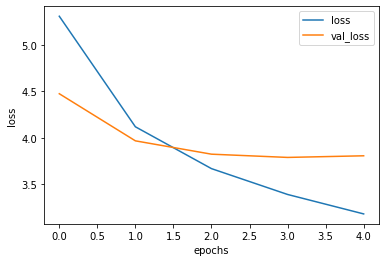

In [ ]:
# using rnn_1 and vgg16
import matplotlib.pyplot as plt

for label in ["loss","val_loss"]:
    plt.plot(history.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.savefig('models/rnn_1_vgg16_loss.png')
plt.show()

## 8.2. Model 1 InceptionV3

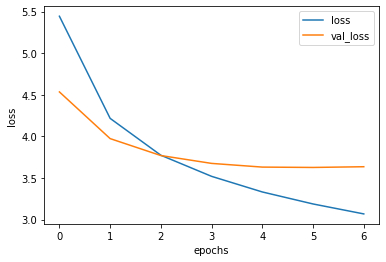

In [ ]:
# using rnn_1 and inceptionv3
import matplotlib.pyplot as plt

for label in ["loss","val_loss"]:
    plt.plot(history.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.savefig('models/rnn_1_inceptionv3_loss.png')
plt.show()

## 8.3. Model 2 VGG16

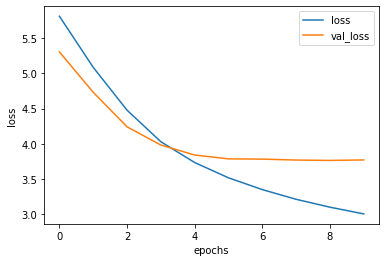

In [36]:
# using rnn_2 and vgg16
import matplotlib.pyplot as plt

for label in ["loss","val_loss"]:
    plt.plot(history.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.savefig('models/rnn_2_vgg16_loss.png')
plt.show()

## 8.4. Model 2 InceptionV3

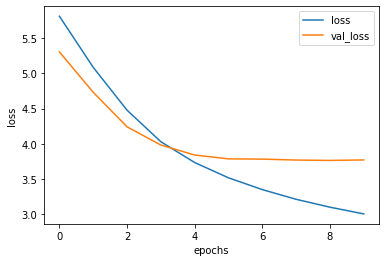

In [47]:
# using rnn_2 and inceptionv3
import matplotlib.pyplot as plt

for label in ["loss","val_loss"]:
    plt.plot(history.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.savefig('models/rnn_2_inceptionv3_loss.png')
plt.show()

# 9. Evaluate Model

## 9.1. Sampling

In [37]:
# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = '<start>'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = tokenizer.index_word[yhat]
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == '<end>':
			break
	return in_text

## 9.2. Beam Search

In [38]:
# generate a description for an image using beam search
def generate_desc_beam_search(model, tokenizer, photo, max_length, beam_index=3):
    # seed the generation process
    in_text = [['<start>', 0.0]]
    # iterate over the whole length of the sequence
    for i in range(max_length):
        temp = []
        for s in in_text:
            # integer encode input sequence
            sequence = tokenizer.texts_to_sequences([s[0]])[0]
            # pad input
            sequence = pad_sequences([sequence], maxlen=max_length)
            # predict next words
            preds = model.predict([photo,sequence], verbose=0)
            word_preds = argsort(preds[0])[-beam_index:]
            # get top predictions
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                # map integer to word
                word = tokenizer.index_word[w]
                next_cap += ' ' + word
                prob += preds[0][w]
                temp.append([next_cap, prob])

        in_text = temp
        # sorting according to the probabilities
        in_text = sorted(in_text, reverse=False, key=lambda l: l[1])
        # getting the top words
        in_text = in_text[-beam_index:]

    # get last (best) caption text
    in_text = in_text[-1][0]
    caption_list = []
    # remove leftover <end> 
    for w in in_text.split():
        caption_list.append(w)
        if w == '<end>':
            break
    # convert list to string
    caption = ' '.join(caption_list)
    return caption

## 9.3. BLEU

In [39]:
def calculate_scores(actual, predicted):
    # calculate BLEU score
    smooth = SmoothingFunction().method4
    bleu1 = corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0), smoothing_function=smooth)*100
    bleu2 = corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth)*100
    bleu3 = corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0), smoothing_function=smooth)*100
    bleu4 = corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth)*100
    print('BLEU-1: %f' % bleu1)
    print('BLEU-2: %f' % bleu2)
    print('BLEU-3: %f' % bleu3)
    print('BLEU-4: %f' % bleu4)

In [40]:
# evaluate the skill of the model
def evaluate_model(model, descriptions, features, tokenizer, max_length):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in tqdm(descriptions.items(), position=0, leave=True):
		# generate description
		yhat = generate_desc(model, tokenizer, features[key], max_length)
		# store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	print('Sampling:')
	calculate_scores(actual, predicted)

In [41]:
# evaluate the skill of the model
def evaluate_model_beam_search(model, descriptions, features, tokenizer, max_length, beam_index=3):
	actual, predicted = list(), list()
	# step over the whole set
	for key, desc_list in tqdm(descriptions.items(), position=0, leave=True):
		# generate description beam search
		yhat = generate_desc_beam_search(model, tokenizer, features[key], max_length, beam_index)
		# store actual and predicted
		references = [d.split() for d in desc_list]
		actual.append(references)
		predicted.append(yhat.split())
	print('Beam Search k=%d:' % beam_index)
	calculate_scores(actual, predicted)

### 9.3.1. Model 1 VGG16

In [ ]:
# load the model
filename = 'models/rnn_model_1_vgg16.h5'
model = load_model(filename)

In [ ]:
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

100%|██████████| 1000/1000 [07:15<00:00,  2.30it/s]


Sampling:
BLEU-1: 54.114390
BLEU-2: 33.489586
BLEU-3: 24.785442
BLEU-4: 13.031321


### 9.3.2. Model 1 InceptionV3

In [ ]:
# load the model
filename = 'models/rnn_model_1_inceptionv3.h5'
model = load_model(filename)

In [ ]:
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

100%|██████████| 1000/1000 [06:48<00:00,  2.45it/s]


Sampling:
BLEU-1: 57.458612
BLEU-2: 34.077377
BLEU-3: 24.426512
BLEU-4: 12.300981


### 9.3.3. Model 2 VGG16

In [ ]:
# load the model
filename = 'models/rnn_model_2_vgg16.h5'
model = load_model(filename)

In [ ]:
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

Sampling:
BLEU-1: 0.595796
BLEU-2: 0.369997
BLEU-3: 0.272431
BLEU-4: 0.144684


### 9.3.4. Model 2 InceptionV3

In [ ]:
# load the model
filename = 'models/rnn_model_2_inceptionv3.h5'
model = load_model(filename)

In [ ]:
# evaluate model
evaluate_model(model, test_descriptions, test_features, tokenizer, max_length)

100%|██████████| 1000/1000 [09:01<00:00,  1.85it/s]


Sampling:
BLEU-1: 0.587866
BLEU-2: 0.366849
BLEU-3: 0.270134
BLEU-4: 0.144244


In [ ]:
# evaluate model beam_search
evaluate_model_beam_search(model, test_descriptions, test_features, tokenizer, max_length, beam_index=3)

 55%|█████▌    | 552/1000 [50:39<40:36,  5.44s/it]

# 10. Generate Captions

In [42]:
def clean_caption(caption):
    # split caption words
    caption_list = caption.split()
    # remove <start> and <end>
    caption_list = caption_list[1:len(caption_list)-1]
    # convert list to string
    caption = ' '.join(caption_list)
    return caption

In [43]:
def generate_captions(model, descriptions, features, image_size, count):
    c = 0
    for key, desc_list in descriptions.items():
        # load an image from file
        filename = 'Flickr8k_Dataset/' + key + '.jpg'
        #diplay image
        display(Image(filename))
        # print original descriptions
        for i, desc in enumerate(desc_list):
            print('Original ' + str(i+1) + ': ' + clean_caption(desc_list[i]))
        # generate descriptions
        desc = generate_desc(model, tokenizer, features[key], max_length)
        desc_beam_3 = generate_desc_beam_search(model, tokenizer, features[key], max_length, beam_index=3)
        desc_beam_5 = generate_desc_beam_search(model, tokenizer, features[key], max_length, beam_index=5)
        # calculate BLEU-1 scores
        references = [d.split() for d in desc_list]
        smooth = SmoothingFunction().method4
        desc_bleu = sentence_bleu(references, desc.split(), weights=(1.0, 0, 0, 0), smoothing_function=smooth)*100
        desc_beam_3_bleu = sentence_bleu(references, desc_beam_3.split(), weights=(1.0, 0, 0, 0), smoothing_function=smooth)*100
        desc_beam_5_bleu = sentence_bleu(references, desc_beam_5.split(), weights=(1.0, 0, 0, 0), smoothing_function=smooth)*100
        # print descriptions with scores
        print('Sampling (BLEU-1: %f): %s' % (desc_bleu, clean_caption(desc)))
        print('Beam Search k=3 (BLEU-1: %f): %s' % (desc_beam_3_bleu, clean_caption(desc_beam_3)))
        print('Beam Search k=5 (BLEU-1: %f): %s' % (desc_beam_5_bleu, clean_caption(desc_beam_5)))
        c += 1
        if c == count:
            break

In [44]:
# load the tokenizer
tokenizer = load(open('files/tokenizer.pkl', 'rb'))

## 10.1. Model 1 VGG16

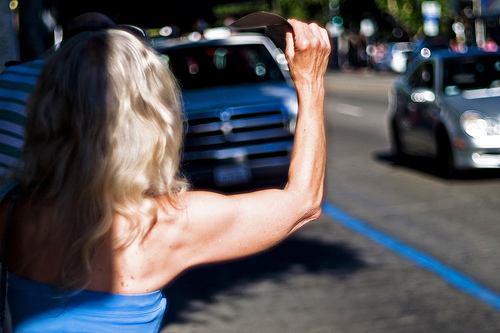

Original 1: blond woman in blue shirt appears to wait for ride
Original 2: blond woman is on the street hailing taxi
Original 3: woman is signaling is to traffic as seen from behind
Original 4: woman with blonde hair wearing blue tube top is waving on the side of the street
Original 5: the woman in the blue dress is holding out her arm at oncoming traffic
Sampling (BLEU-1: 69.230769): man in blue shirt and sunglasses is sitting on the street
Beam Search k=3 (BLEU-1: 60.000000): man and woman are sitting on the street
Beam Search k=5 (BLEU-1: 50.000000): man and woman are sitting on the middle of camera


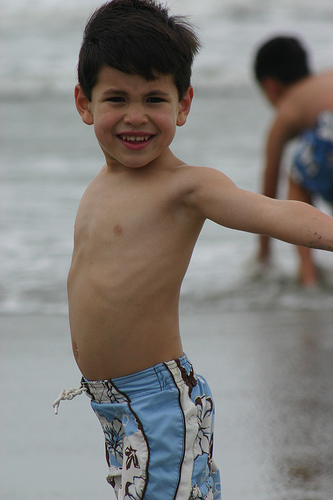

Original 1: boy in his blue swim shorts at the beach
Original 2: boy smiles for the camera at beach
Original 3: young boy in swimming trunks is walking with his arms outstretched on the beach
Original 4: children playing on the beach
Original 5: the boy is playing on the shore of an ocean
Sampling (BLEU-1: 81.818182): boy in blue shirt is standing on the beach
Beam Search k=3 (BLEU-1: 83.333333): little boy in blue shirt is walking on the beach
Beam Search k=5 (BLEU-1: 83.333333): little boy in blue shirt is walking on the beach


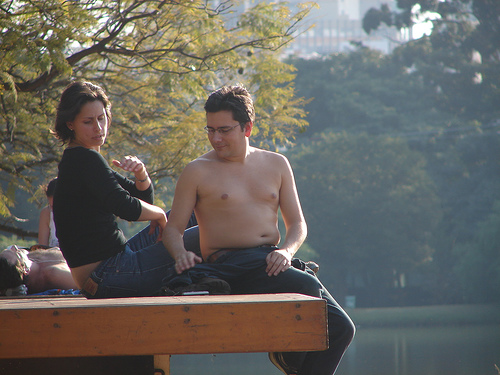

Original 1: lady and man with no shirt sit on dock
Original 2: man and woman are sitting on dock together
Original 3: man and woman sitting on dock
Original 4: man and woman sitting on deck next to lake
Original 5: shirtless man and woman sitting on dock
Sampling (BLEU-1: 60.000000): man in blue shirt is sitting on bench
Beam Search k=3 (BLEU-1: 36.363636): young boy is sitting on bench in the park
Beam Search k=5 (BLEU-1: 41.666667): the man is sitting on bench in front of park


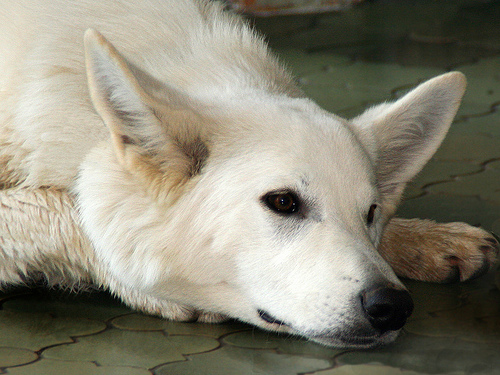

Original 1: closeup of white dog that is laying its head on its paws
Original 2: large white dog lying on the floor
Original 3: white dog has its head on the ground
Original 4: white dog is resting its head on tiled floor with its eyes open
Original 5: white dog rests its head on the patio bricks
Sampling (BLEU-1: 66.666667): white dog is running through the air
Beam Search k=3 (BLEU-1: 42.736665): white and white and white dog is standing in its mouth
Beam Search k=5 (BLEU-1: 42.736665): white and white and white dog is standing in its mouth


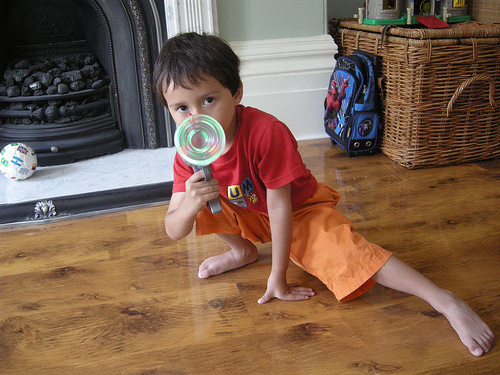

Original 1: boy with toy gun
Original 2: little boy in orange shorts playing with toy
Original 3: young boy with his foot outstretched aims toy at the camera in front of fireplace
Original 4: young child plays with his new lightup toy
Original 5: boy with toy gun pointed at the camera
Sampling (BLEU-1: 45.454545): boy in blue shirt is sitting on the ground
Beam Search k=3 (BLEU-1: 50.000000): young boy in blue shirt is sitting on the water
Beam Search k=5 (BLEU-1: 50.000000): little boy in blue shirt is sitting on the beach


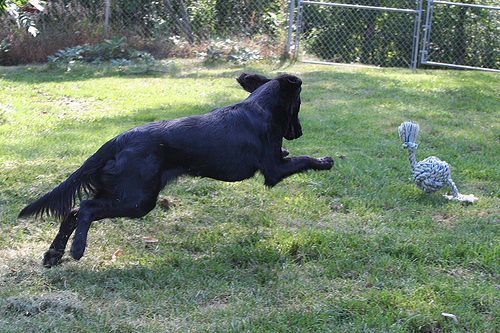

Original 1: black dog jumping to catch rope toy
Original 2: black dog playing fetch with ball of rope
Original 3: black dog pounces to get rope toy
Original 4: black dog running after his rope toy
Original 5: large black dog is playing in grassy yard
Sampling (BLEU-1: 66.666667): black dog is running through the grass
Beam Search k=3 (BLEU-1: 66.666667): black dog is running through the grass
Beam Search k=5 (BLEU-1: 44.124845): black dog runs through the grass


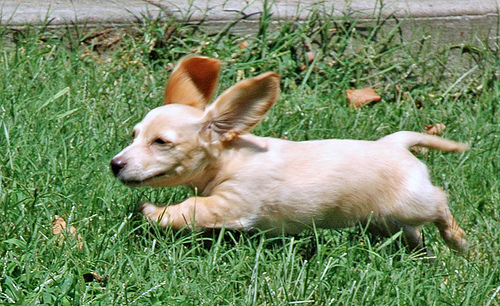

Original 1: little tan dog with large ears running through the grass
Original 2: playful dog is running through the grass
Original 3: small dogs ears stick up as it runs in the grass
Original 4: the small dog is running across the lawn
Original 5: this is small beige dog running through grassy field
Sampling (BLEU-1: 77.777778): two dogs are running in the grass
Beam Search k=3 (BLEU-1: 66.187268): two dogs play in the grass
Beam Search k=5 (BLEU-1: 70.000000): brown and white dog running through the grass


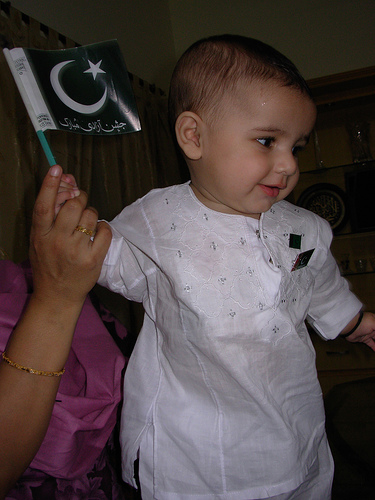

Original 1: baby in white garment holds flag with crescent moon and star
Original 2: baby is holding small black flag with moon and star on it
Original 3: baby wearing white gown waves muslim flag
Original 4: little toddler dressed in white is smiling while lady helps him wave flag
Original 5: baby in white outfit holding black and white flag
Sampling (BLEU-1: 33.333333): two children are sitting on the camera
Beam Search k=3 (BLEU-1: 41.666667): young boy in blue shirt is sitting on the camera
Beam Search k=5 (BLEU-1: 41.666667): young boy in blue shirt is sitting on the camera


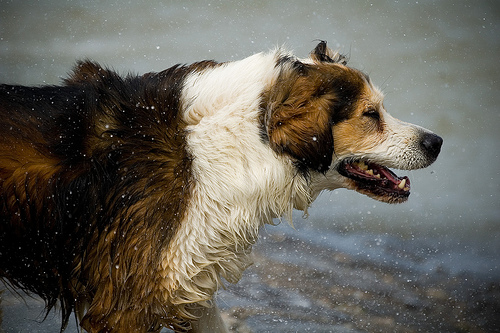

Original 1: brown and white dog stands outside while it snows
Original 2: dog is looking at something near the water
Original 3: furry dog attempts to dry itself by shaking the water off its coat
Original 4: white and brown dog shaking its self dry
Original 5: the large brown and white dog shakes off water
Sampling (BLEU-1: 69.598614): white dog is running through the water
Beam Search k=3 (BLEU-1: 11.428571): white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white
Beam Search k=5 (BLEU-1: 11.428571): black and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white and white


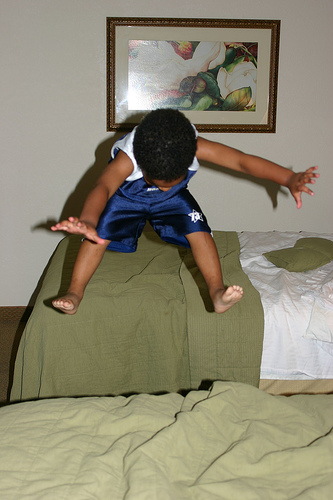

Original 1: boy is jumping on bed
Original 2: boy jumped up from the green bed
Original 3: boy jumps from one bed to another
Original 4: small child is jumping on bed
Original 5: the boy in blue shorts is bouncing on the bed
Sampling (BLEU-1: 75.000000): young boy in blue shirt is sitting on the bed
Beam Search k=3 (BLEU-1: 77.777778): the little boy is sitting on bed
Beam Search k=5 (BLEU-1: 75.000000): little boy is sitting on bed


In [ ]:
# load the model
filename = 'models/rnn_model_1_vgg16.h5'
rnn_model = load_model(filename)
# using rnn_2 and vgg16 model
generate_captions(rnn_model, test_descriptions, test_features, 224, 10)

## 10.2. Model 1 InceptionV3

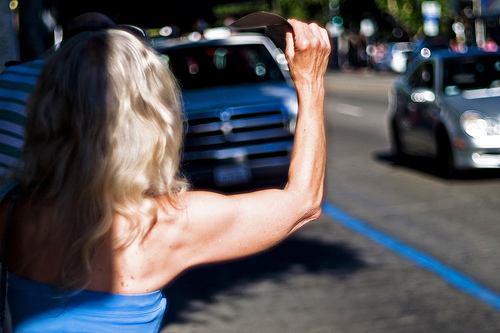

Original 1: blond woman in blue shirt appears to wait for ride
Original 2: blond woman is on the street hailing taxi
Original 3: woman is signaling is to traffic as seen from behind
Original 4: woman with blonde hair wearing blue tube top is waving on the side of the street
Original 5: the woman in the blue dress is holding out her arm at oncoming traffic
Sampling (BLEU-1: 56.250000): man in blue jacket and blue hat is holding his head on the street
Beam Search k=3 (BLEU-1: 62.500000): man in blue shirt and blue hat is holding his arms on the street
Beam Search k=5 (BLEU-1: 58.333333): young boy in blue jacket is sitting on the beach


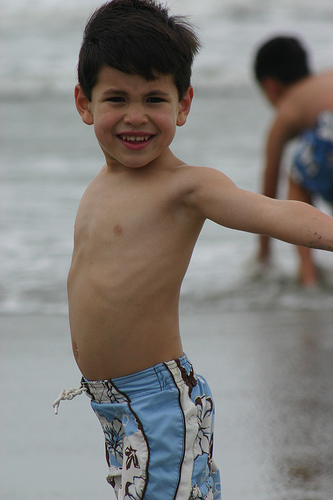

Original 1: boy in his blue swim shorts at the beach
Original 2: boy smiles for the camera at beach
Original 3: young boy in swimming trunks is walking with his arms outstretched on the beach
Original 4: children playing on the beach
Original 5: the boy is playing on the shore of an ocean
Sampling (BLEU-1: 56.130419): young boy in blue bathing suit is holding his head in the water
Beam Search k=3 (BLEU-1: 61.538462): young boy in blue bathing suit is running in the water
Beam Search k=5 (BLEU-1: 69.230769): young boy in blue bathing suit is playing in the water


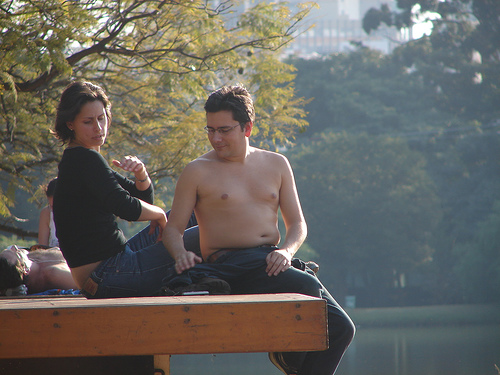

Original 1: lady and man with no shirt sit on dock
Original 2: man and woman are sitting on dock together
Original 3: man and woman sitting on dock
Original 4: man and woman sitting on deck next to lake
Original 5: shirtless man and woman sitting on dock
Sampling (BLEU-1: 58.333333): man in blue shirt and jeans is sitting on bench
Beam Search k=3 (BLEU-1: 38.461538): the man is sitting on bench in front of the ocean
Beam Search k=5 (BLEU-1: 38.461538): the man is sitting on bench in front of white building


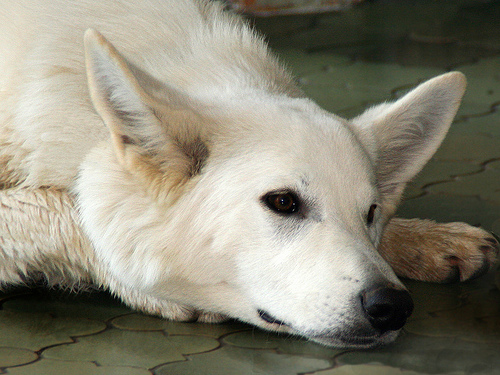

Original 1: closeup of white dog that is laying its head on its paws
Original 2: large white dog lying on the floor
Original 3: white dog has its head on the ground
Original 4: white dog is resting its head on tiled floor with its eyes open
Original 5: white dog rests its head on the patio bricks
Sampling (BLEU-1: 55.156056): dog is running through the air
Beam Search k=3 (BLEU-1: 54.545455): white and white dog is running through the woods
Beam Search k=5 (BLEU-1: 50.000000): white and white dog runs through the woods


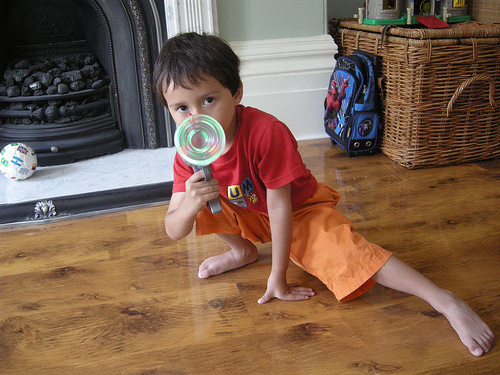

Original 1: boy with toy gun
Original 2: little boy in orange shorts playing with toy
Original 3: young boy with his foot outstretched aims toy at the camera in front of fireplace
Original 4: young child plays with his new lightup toy
Original 5: boy with toy gun pointed at the camera
Sampling (BLEU-1: 29.411765): man in blue shirt is sitting on the edge of the edge of the water
Beam Search k=3 (BLEU-1: 23.337955): the man is sitting on the edge of the edge of the water
Beam Search k=5 (BLEU-1: 54.545455): young boy is sitting on the edge of water


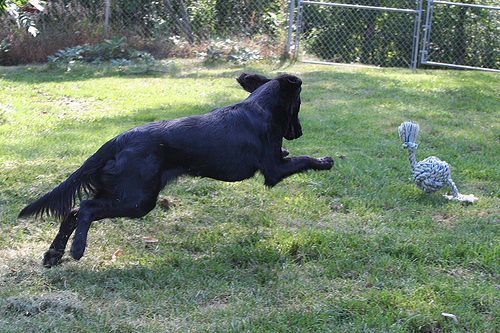

Original 1: black dog jumping to catch rope toy
Original 2: black dog playing fetch with ball of rope
Original 3: black dog pounces to get rope toy
Original 4: black dog running after his rope toy
Original 5: large black dog is playing in grassy yard
Sampling (BLEU-1: 66.666667): black dog is running through the water
Beam Search k=3 (BLEU-1: 55.156056): black dog running through the water
Beam Search k=5 (BLEU-1: 44.124845): black dog runs through the water


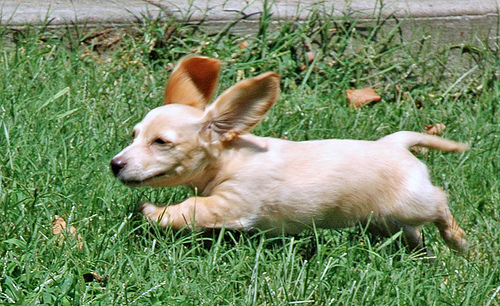

Original 1: little tan dog with large ears running through the grass
Original 2: playful dog is running through the grass
Original 3: small dogs ears stick up as it runs in the grass
Original 4: the small dog is running across the lawn
Original 5: this is small beige dog running through grassy field
Sampling (BLEU-1: 88.888889): white dog is running through the grass
Beam Search k=3 (BLEU-1: 72.727273): brown and white dog is running through the grass
Beam Search k=5 (BLEU-1: 70.000000): brown and white dog runs through the grass


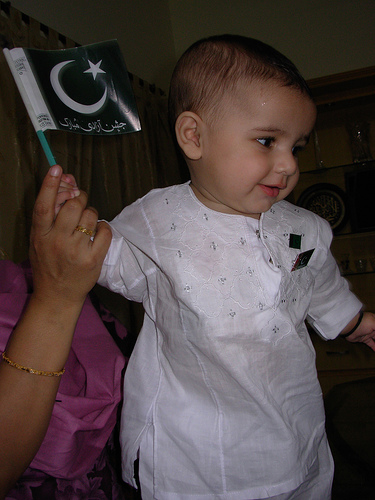

Original 1: baby in white garment holds flag with crescent moon and star
Original 2: baby is holding small black flag with moon and star on it
Original 3: baby wearing white gown waves muslim flag
Original 4: little toddler dressed in white is smiling while lady helps him wave flag
Original 5: baby in white outfit holding black and white flag
Sampling (BLEU-1: 45.454545): man in blue shirt is sitting on the camera
Beam Search k=3 (BLEU-1: 45.454545): young boy in blue shirt is sitting on bed
Beam Search k=5 (BLEU-1: 45.454545): young boy in blue shirt is sitting on bed


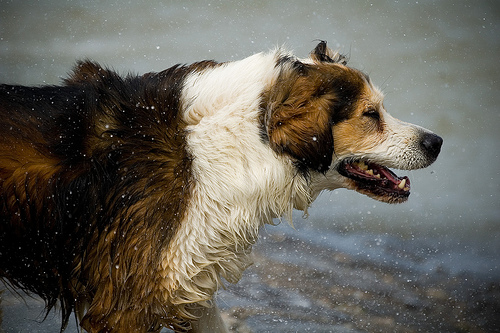

Original 1: brown and white dog stands outside while it snows
Original 2: dog is looking at something near the water
Original 3: furry dog attempts to dry itself by shaking the water off its coat
Original 4: white and brown dog shaking its self dry
Original 5: the large brown and white dog shakes off water
Sampling (BLEU-1: 69.598614): white dog is swimming in the water
Beam Search k=3 (BLEU-1: 80.000000): brown and white dog swims in the water
Beam Search k=5 (BLEU-1: 80.000000): brown and white dog swims in the water


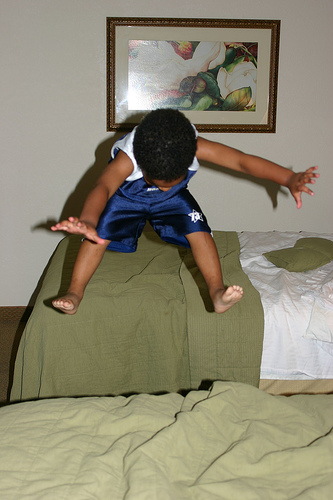

Original 1: boy is jumping on bed
Original 2: boy jumped up from the green bed
Original 3: boy jumps from one bed to another
Original 4: small child is jumping on bed
Original 5: the boy in blue shorts is bouncing on the bed
Sampling (BLEU-1: 70.000000): man in blue shirt is sitting on bed
Beam Search k=3 (BLEU-1: 70.000000): man in blue shirt is sitting on bed
Beam Search k=5 (BLEU-1: 62.500000): little girl is sitting on bed


In [ ]:
# load the model
filename = 'models/rnn_model_1_inceptionv3.h5'
rnn_model = load_model(filename)
# using rnn_2 and inceptionv3 model
generate_captions(rnn_model, test_descriptions, test_features, 299, 10)

## 10.3. Model 2 VGG16

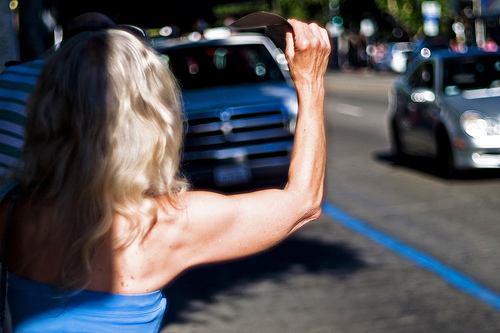

Original 1: blond woman in blue shirt appears to wait for ride
Original 2: blond woman is on the street hailing taxi
Original 3: woman is signaling is to traffic as seen from behind
Original 4: woman with blonde hair wearing blue tube top is waving on the side of the street
Original 5: the woman in the blue dress is holding out her arm at oncoming traffic
Sampling (BLEU-1: 58.410059): man is sitting on the street
Beam Search k=3 (BLEU-1: 69.598614): the man is sitting on the street
Beam Search k=5 (BLEU-1: 69.598614): the man is sitting on the street


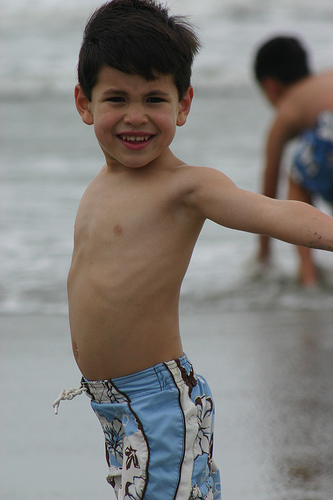

Original 1: boy in his blue swim shorts at the beach
Original 2: boy smiles for the camera at beach
Original 3: young boy in swimming trunks is walking with his arms outstretched on the beach
Original 4: children playing on the beach
Original 5: the boy is playing on the shore of an ocean
Sampling (BLEU-1: 85.714286): young boy in the sand
Beam Search k=3 (BLEU-1: 85.714286): young boy in the sand
Beam Search k=5 (BLEU-1: 85.714286): young boy in the sand


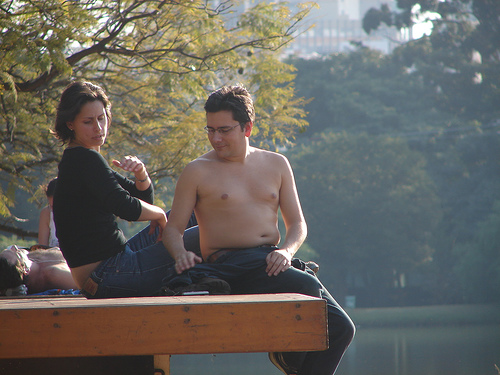

Original 1: lady and man with no shirt sit on dock
Original 2: man and woman are sitting on dock together
Original 3: man and woman sitting on dock
Original 4: man and woman sitting on deck next to lake
Original 5: shirtless man and woman sitting on dock
Sampling (BLEU-1: 37.500000): man is jumping off of skateboard
Beam Search k=3 (BLEU-1: 37.151910): man jumps off of skateboard
Beam Search k=5 (BLEU-1: 55.555556): man on skateboard is sitting on rail


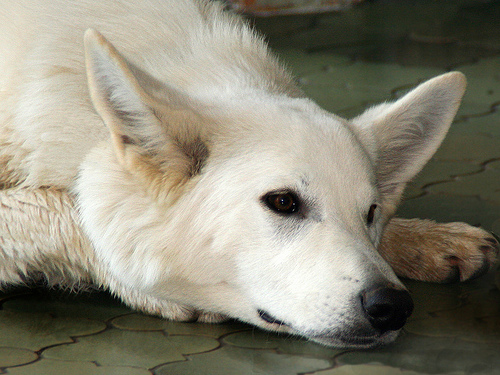

Original 1: closeup of white dog that is laying its head on its paws
Original 2: large white dog lying on the floor
Original 3: white dog has its head on the ground
Original 4: white dog is resting its head on tiled floor with its eyes open
Original 5: white dog rests its head on the patio bricks
Sampling (BLEU-1: 33.333333): two dogs are playing in the grass
Beam Search k=3 (BLEU-1: 55.156056): white dog looks at the steps
Beam Search k=5 (BLEU-1: 66.187268): white dog looks at the ground


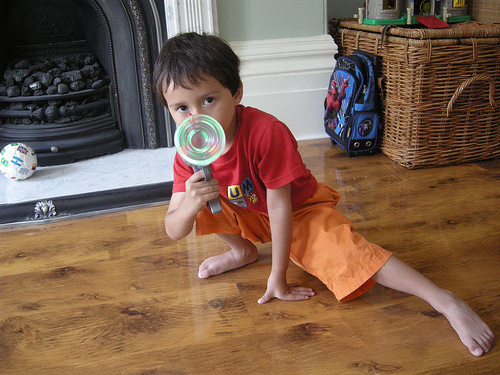

Original 1: boy with toy gun
Original 2: little boy in orange shorts playing with toy
Original 3: young boy with his foot outstretched aims toy at the camera in front of fireplace
Original 4: young child plays with his new lightup toy
Original 5: boy with toy gun pointed at the camera
Sampling (BLEU-1: 50.000000): the little boy is sitting on the floor
Beam Search k=3 (BLEU-1: 60.000000): the little boy is sitting in the grass
Beam Search k=5 (BLEU-1: 60.000000): the little boy is sitting in the grass


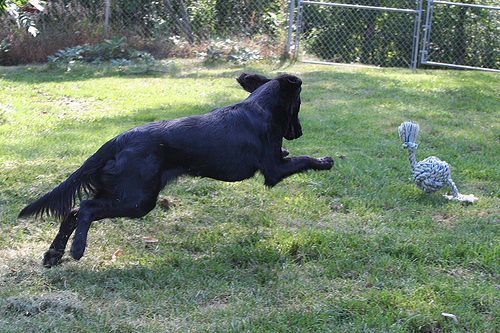

Original 1: black dog jumping to catch rope toy
Original 2: black dog playing fetch with ball of rope
Original 3: black dog pounces to get rope toy
Original 4: black dog running after his rope toy
Original 5: large black dog is playing in grassy yard
Sampling (BLEU-1: 66.666667): black dog is running on the grass
Beam Search k=3 (BLEU-1: 70.000000): the black dog is running in the grass
Beam Search k=5 (BLEU-1: 54.545455): black dog and black dog running in the grass


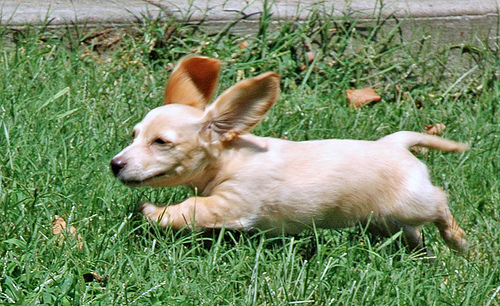

Original 1: little tan dog with large ears running through the grass
Original 2: playful dog is running through the grass
Original 3: small dogs ears stick up as it runs in the grass
Original 4: the small dog is running across the lawn
Original 5: this is small beige dog running through grassy field
Sampling (BLEU-1: 44.124845): two dogs are playing with ball
Beam Search k=3 (BLEU-1: 60.000000): two brown dogs are playing in the grass
Beam Search k=5 (BLEU-1: 66.666667): brown dog is playing with tennis ball in the grass


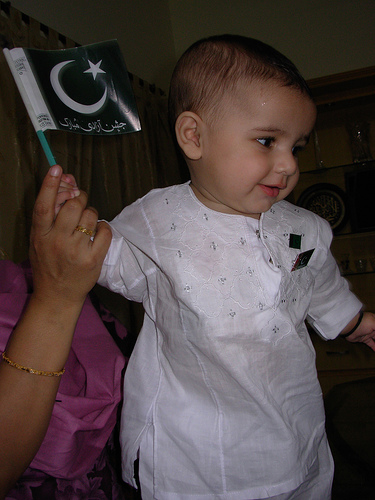

Original 1: baby in white garment holds flag with crescent moon and star
Original 2: baby is holding small black flag with moon and star on it
Original 3: baby wearing white gown waves muslim flag
Original 4: little toddler dressed in white is smiling while lady helps him wave flag
Original 5: baby in white outfit holding black and white flag
Sampling (BLEU-1: 30.000000): two young girls are playing with each other
Beam Search k=3 (BLEU-1: 30.000000): two young girls are sitting in the room
Beam Search k=5 (BLEU-1: 22.222222): two young girls are posing for picture


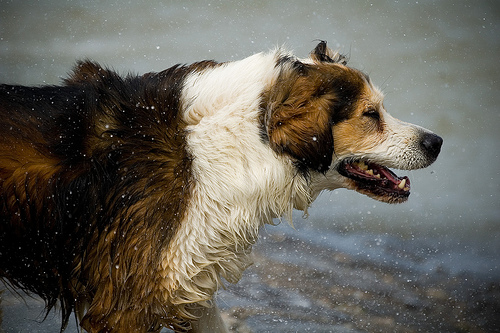

Original 1: brown and white dog stands outside while it snows
Original 2: dog is looking at something near the water
Original 3: furry dog attempts to dry itself by shaking the water off its coat
Original 4: white and brown dog shaking its self dry
Original 5: the large brown and white dog shakes off water
Sampling (BLEU-1: 34.227808): dog with its mouth
Beam Search k=3 (BLEU-1: 59.655954): black and white dog in the sand
Beam Search k=5 (BLEU-1: 59.655954): black and white dog in the snow


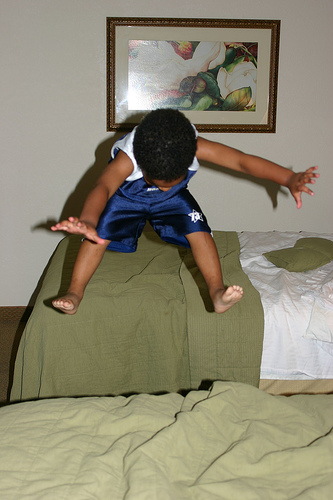

Original 1: boy is jumping on bed
Original 2: boy jumped up from the green bed
Original 3: boy jumps from one bed to another
Original 4: small child is jumping on bed
Original 5: the boy in blue shorts is bouncing on the bed
Sampling (BLEU-1: 90.000000): the little boy is jumping on the bed
Beam Search k=3 (BLEU-1: 77.777778): the little boy is in the tunnel
Beam Search k=5 (BLEU-1: 77.777778): the little boy is in the air


In [45]:
# load the model
filename = 'models/rnn_model_2_vgg16.h5'
rnn_model = load_model(filename)
# using rnn_2 and vgg16 model
generate_captions(rnn_model, test_descriptions, test_features, 224, 10)

## 10.4. Model 2 InceptionV3

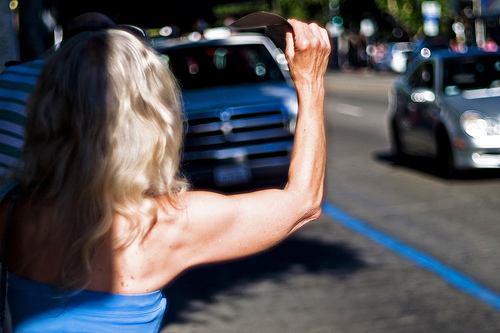

Original 1: blond woman in blue shirt appears to wait for ride
Original 2: blond woman is on the street hailing taxi
Original 3: woman is signaling is to traffic as seen from behind
Original 4: woman with blonde hair wearing blue tube top is waving on the side of the street
Original 5: the woman in the blue dress is holding out her arm at oncoming traffic
Sampling (BLEU-1: 0.500000): the boy is wearing red hat and is wearing helmet
Beam Search k=3 (BLEU-1: 0.600000): the boy is wearing red shirt and helmet
Beam Search k=5 (BLEU-1: 0.500000): young boy wearing helmet and blue shirt is wearing helmet


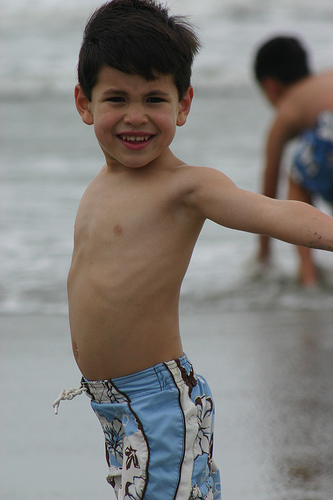

Original 1: boy in his blue swim shorts at the beach
Original 2: boy smiles for the camera at beach
Original 3: young boy in swimming trunks is walking with his arms outstretched on the beach
Original 4: children playing on the beach
Original 5: the boy is playing on the shore of an ocean
Sampling (BLEU-1: 0.636364): boy in blue shirt is standing in the water
Beam Search k=3 (BLEU-1: 0.714286): little boy in swimming pool
Beam Search k=5 (BLEU-1: 0.857143): young boy in swimming pool


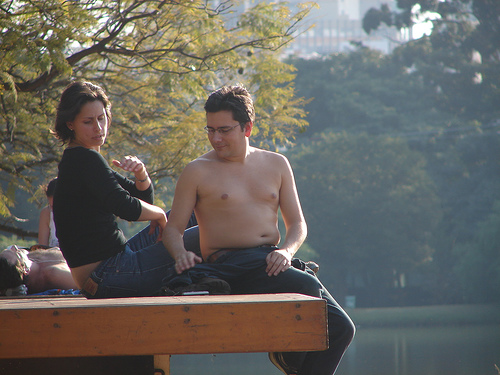

Original 1: lady and man with no shirt sit on dock
Original 2: man and woman are sitting on dock together
Original 3: man and woman sitting on dock
Original 4: man and woman sitting on deck next to lake
Original 5: shirtless man and woman sitting on dock
Sampling (BLEU-1: 0.600000): man in blue shirt is sitting on bench
Beam Search k=3 (BLEU-1: 0.400000): the man in the blue shirt is sitting on the top of rock
Beam Search k=5 (BLEU-1: 0.400000): the man in the blue shirt is sitting on the top of rock


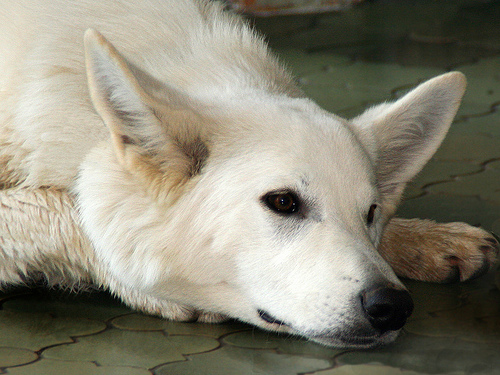

Original 1: closeup of white dog that is laying its head on its paws
Original 2: large white dog lying on the floor
Original 3: white dog has its head on the ground
Original 4: white dog is resting its head on tiled floor with its eyes open
Original 5: white dog rests its head on the patio bricks
Sampling (BLEU-1: 0.500000): dog is jumping over log in the air
Beam Search k=3 (BLEU-1: 0.600000): the white dog is running through the snow
Beam Search k=5 (BLEU-1: 0.583333): the white dog is in the middle of the snow


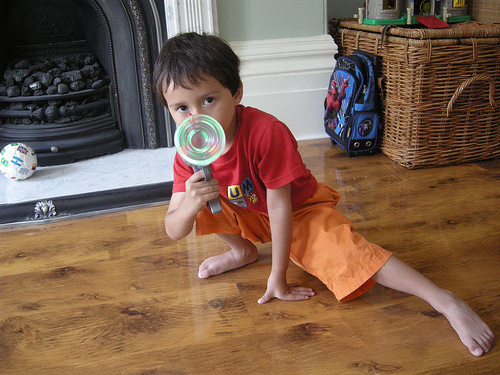

Original 1: boy with toy gun
Original 2: little boy in orange shorts playing with toy
Original 3: young boy with his foot outstretched aims toy at the camera in front of fireplace
Original 4: young child plays with his new lightup toy
Original 5: boy with toy gun pointed at the camera
Sampling (BLEU-1: 0.298280): boy is holding baby on her face
Beam Search k=3 (BLEU-1: 0.666667): the little boy is standing in front of some water
Beam Search k=5 (BLEU-1: 0.461210): the little boy in the blue shirt is playing with brown dog


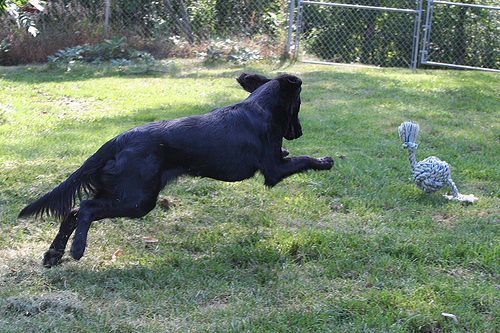

Original 1: black dog jumping to catch rope toy
Original 2: black dog playing fetch with ball of rope
Original 3: black dog pounces to get rope toy
Original 4: black dog running after his rope toy
Original 5: large black dog is playing in grassy yard
Sampling (BLEU-1: 0.666667): black dog is jumping into the air
Beam Search k=3 (BLEU-1: 0.600000): the black dog is running through the grass
Beam Search k=5 (BLEU-1: 0.600000): the black dog is running through the grass


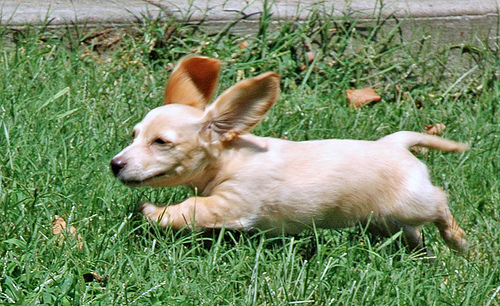

Original 1: little tan dog with large ears running through the grass
Original 2: playful dog is running through the grass
Original 3: small dogs ears stick up as it runs in the grass
Original 4: the small dog is running across the lawn
Original 5: this is small beige dog running through grassy field
Sampling (BLEU-1: 0.882497): dog is running through the grass
Beam Search k=3 (BLEU-1: 0.666667): white dog is playing with green ball in the grass
Beam Search k=5 (BLEU-1: 0.666667): white dog is playing with red ball in the grass


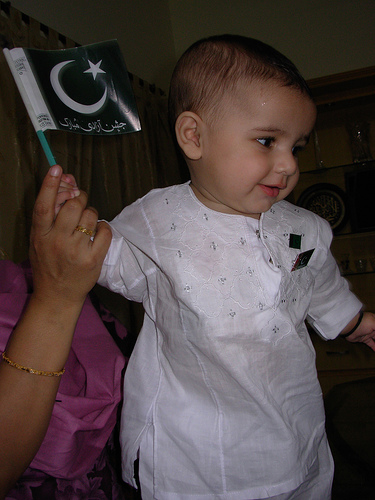

Original 1: baby in white garment holds flag with crescent moon and star
Original 2: baby is holding small black flag with moon and star on it
Original 3: baby wearing white gown waves muslim flag
Original 4: little toddler dressed in white is smiling while lady helps him wave flag
Original 5: baby in white outfit holding black and white flag
Sampling (BLEU-1: 0.454545): boy with his head is holding up his head
Beam Search k=3 (BLEU-1: 0.416667): young boy is holding spoon in front of brick wall
Beam Search k=5 (BLEU-1: 0.545455): little boy in blue shirt is playing with bubble


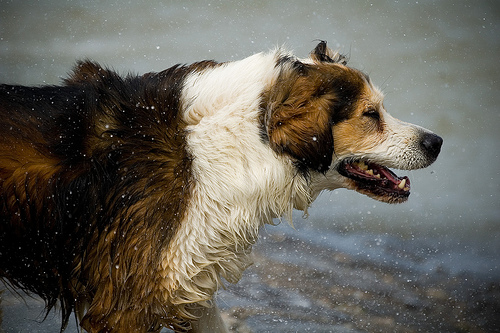

Original 1: brown and white dog stands outside while it snows
Original 2: dog is looking at something near the water
Original 3: furry dog attempts to dry itself by shaking the water off its coat
Original 4: white and brown dog shaking its self dry
Original 5: the large brown and white dog shakes off water
Sampling (BLEU-1: 0.584101): dog is swimming in the water
Beam Search k=3 (BLEU-1: 0.727273): white and white dog is swimming in the water
Beam Search k=5 (BLEU-1: 0.700000): brown and white dog swims in shallow water


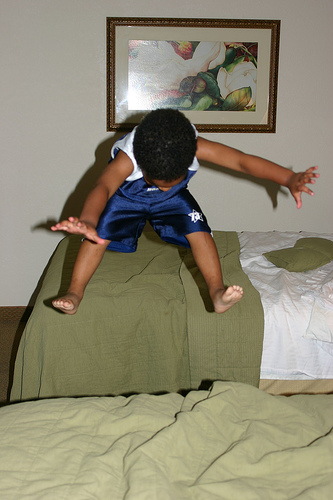

Original 1: boy is jumping on bed
Original 2: boy jumped up from the green bed
Original 3: boy jumps from one bed to another
Original 4: small child is jumping on bed
Original 5: the boy in blue shorts is bouncing on the bed
Sampling (BLEU-1: 0.500000): two children are sitting on bed
Beam Search k=3 (BLEU-1: 0.664073): young boy in blue shirt is sitting on bed
Beam Search k=5 (BLEU-1: 0.664073): little boy in blue shirt is sitting on bed


In [ ]:
# load the model
filename = 'models/rnn_model_2_inceptionv3.h5'
rnn_model = load_model(filename)
# using rnn_2 and inceptionv3 model
generate_captions(rnn_model, test_descriptions, test_features, 299, 10)